In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV

In [6]:
file = '../Resampling/FCV_Oversampled.csv'
df = pd.read_csv(file)

df

,Previous PHEVs,Previous BEVs,Previous HEVs,Previous CNGs,Household Income,"Importance of reducing greenhouse gas emissions (-3 not important, 3 important)",Home ownership (own 1),Home Type (detached 1),Highest Level of Education,Longest trip in the last 12 months,...,One-way commute distance,Number of people in the household,Age,Gender (Male 1),Number of vehicles in the household,Annual VMT Estimate,Target,Model Year,Manufacturer,Model
0,0,0,0,0,125000.0,-2,1,1,3,571.75,...,15.58,2,55,0,3,10992,1.0,2013,4,4
1,0,0,1,0,225000.0,1,1,1,4,120.40,...,2.19,2,55,0,2,5714,1.0,2014,1,13
2,0,0,0,0,375000.0,2,1,1,3,407.45,...,40.95,5,45,0,2,16800,1.0,2013,9,6
3,0,0,1,0,275000.0,2,1,1,4,123.65,...,3.04,3,45,0,2,6000,1.0,2012,9,6
4,0,0,0,0,125000.0,0,1,1,4,289.51,...,47.75,2,65,0,2,14250,1.0,2014,12,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6629,0,0,1,0,275000.0,2,1,1,4,568.09,...,10.69,3,65,0,3,9197,0.0,2016,12,7
6630,0,0,1,0,225000.0,2,0,0,4,788.46,...,24.94,2,35,0,3,12800,0.0,2015,5,14
6631,0,0,0,0,225000.0,0,1,1,4,395.48,...,33.58,4,55,0,2,21600,0.0,2017,12,7
6632,0,0,0,0,75000.0,0,1,0,2,447.83,...,4.52,2,65,0,2,14880,0.0,2017,4,3


In [7]:
ml_df = df.copy()

In [8]:
# Seperate training data from target column

X = ml_df.drop(columns=('Target'), axis = 1)
y = ml_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [9]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [10]:
rr = RidgeClassifier(alpha=1)

In [11]:
rr.fit(X_train_scaled, y_train)

RidgeClassifier(alpha=1)

In [12]:
y_pred = rr.predict(X_test_scaled)
results = pd.DataFrame({
   "Prediction": y_pred,
   "Actual": y_test,
}).reset_index(drop=True)
results

,Prediction,Actual
0,1.0,1.0
1,0.0,0.0
2,0.0,0.0
3,1.0,1.0
4,0.0,0.0
...,...,...
1986,0.0,0.0
1987,1.0,0.0
1988,0.0,1.0
1989,1.0,1.0


In [13]:
# Evaluate the model
ovr_accuracy_score = accuracy_score(y_test, y_pred)
ovr_accuracy_score

0.8307383224510296

In [14]:
# Stealing Christy's metric score function ;)
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['BEV (0)', 'FCV (1)'], yticklabels=['BEV (0)', 'FCV (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84       976
         1.0       0.89      0.77      0.82      1015

    accuracy                           0.83      1991
   macro avg       0.84      0.83      0.83      1991
weighted avg       0.84      0.83      0.83      1991



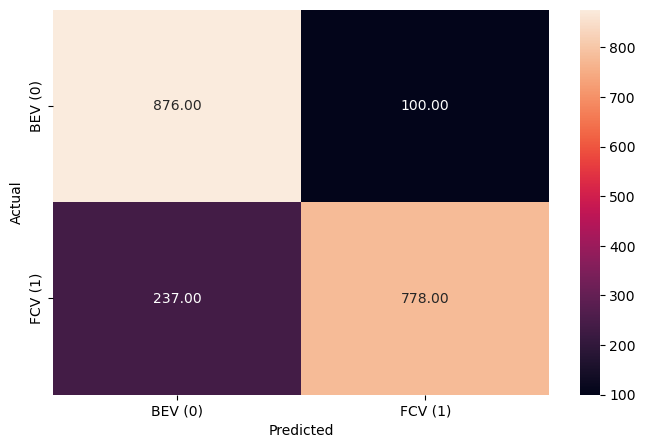

In [15]:
metrics_score(y_test, y_pred)

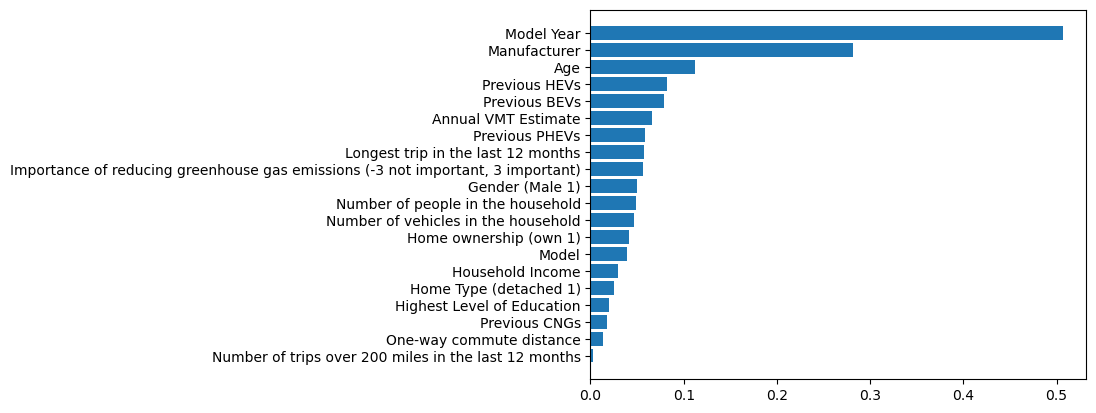

In [18]:
# Calculate feature importance on Ridge Model

coef = rr.coef_
feature_importance = np.abs(coef)

# Plot feature importance

def f_importances(coef, names):
    imp = coef[0]
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


f_importances(feature_importance, list(X.columns))

In [21]:
param_grid = {'alpha': [0.1, 0.5, 1], 'fit_intercept': [True, False],'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

grid = GridSearchCV(rr,param_grid,refit=True,verbose=1)
grid.fit(X_train_scaled,y_train)
print(grid.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'alpha': 0.5, 'fit_intercept': True, 'solver': 'saga'}


              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84       976
         1.0       0.89      0.77      0.82      1015

    accuracy                           0.83      1991
   macro avg       0.84      0.83      0.83      1991
weighted avg       0.84      0.83      0.83      1991



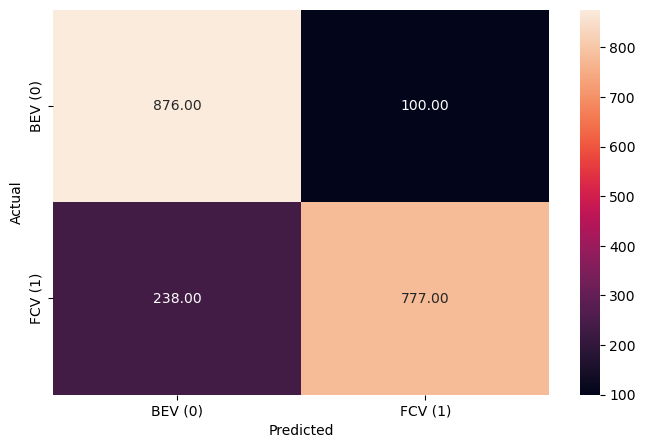

In [22]:
ovr_grid_predictions = grid.predict(X_test_scaled)
ovr_tuned_accuracy_score = accuracy_score(y_test, ovr_grid_predictions)
metrics_score(y_test, ovr_grid_predictions)

## Testing on Weaker Data

In [23]:
data = ml_df.copy()
data = data.drop(columns=['Manufacturer', 'Model', 'Model Year'])

In [24]:
# Seperate training data from target column

X = data.drop(columns=('Target'), axis = 1)
y = data['Target']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [26]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [27]:
rr = RidgeClassifier(alpha=1)

rr.fit(X_train_scaled, y_train)

RidgeClassifier(alpha=1)

In [28]:
y_pred = rr.predict(X_test_scaled)
weak_accuracy_score = accuracy_score(y_test, y_pred)
weak_accuracy_score

0.6122551481667504

              precision    recall  f1-score   support

         0.0       0.60      0.61      0.61       976
         1.0       0.62      0.62      0.62      1015

    accuracy                           0.61      1991
   macro avg       0.61      0.61      0.61      1991
weighted avg       0.61      0.61      0.61      1991



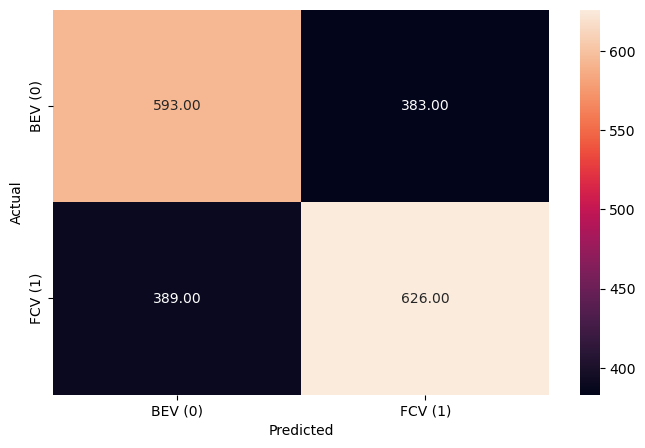

In [29]:
metrics_score(y_test, y_pred)

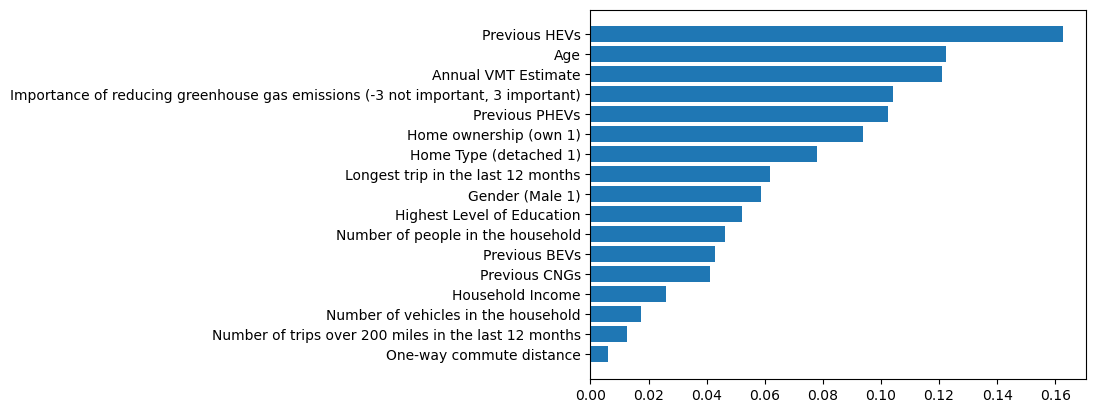

In [30]:
# Calculate feature importance on Ridge Model

coef = rr.coef_
feature_importance = np.abs(coef)

# Plot feature importance

def f_importances(coef, names):
    imp = coef[0]
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


f_importances(feature_importance, list(X.columns))

In [31]:
param_grid = {'alpha': [0.1, 0.5, 1], 'fit_intercept': [True, False],'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

grid = GridSearchCV(rr,param_grid,refit=True,verbose=1)
grid.fit(X_train_scaled,y_train)
print(grid.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'alpha': 0.1, 'fit_intercept': True, 'solver': 'sag'}


              precision    recall  f1-score   support

         0.0       0.60      0.61      0.61       976
         1.0       0.62      0.62      0.62      1015

    accuracy                           0.61      1991
   macro avg       0.61      0.61      0.61      1991
weighted avg       0.61      0.61      0.61      1991



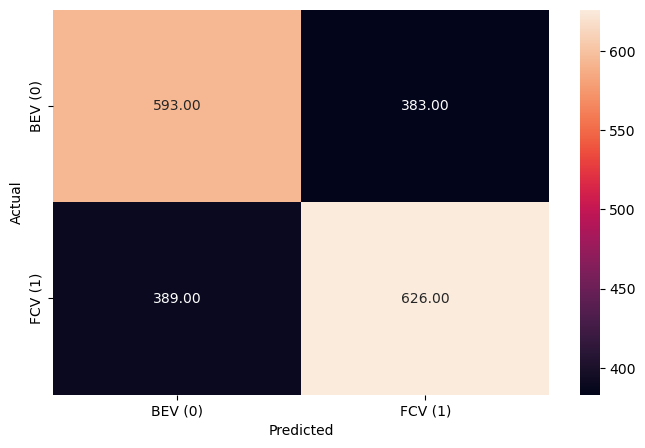

In [33]:
weak_grid_predictions = grid.predict(X_test_scaled)
weak_tuned_accuracy_score = accuracy_score(y_test, weak_grid_predictions)
metrics_score(y_test, weak_grid_predictions)

## Testing on Strong Data

In [34]:
data = ml_df.copy()

In [35]:
# Seperate training data from target column

X = data.drop(columns=('Target'), axis = 1)
X = X[['Manufacturer', 'Model', 'Model Year']]
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [36]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [37]:
rr = RidgeClassifier(alpha=1)

rr.fit(X_train_scaled, y_train)

RidgeClassifier(alpha=1)

In [38]:
y_pred = rr.predict(X_test_scaled)
strong_accuracy_score = accuracy_score(y_test, y_pred)
strong_accuracy_score

0.8342541436464088

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.84       976
         1.0       0.90      0.76      0.82      1015

    accuracy                           0.83      1991
   macro avg       0.84      0.84      0.83      1991
weighted avg       0.84      0.83      0.83      1991



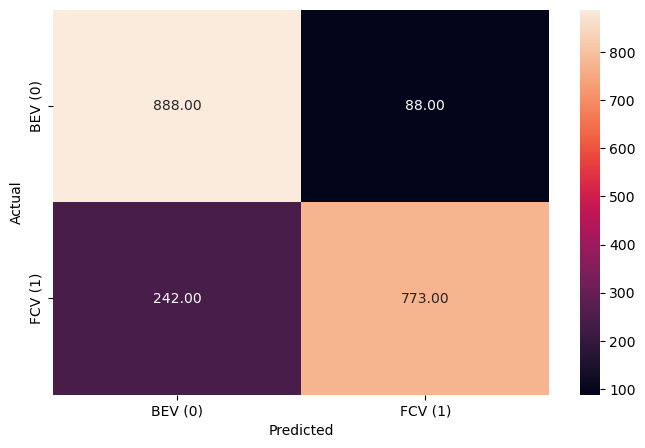

In [39]:
metrics_score(y_test, y_pred)

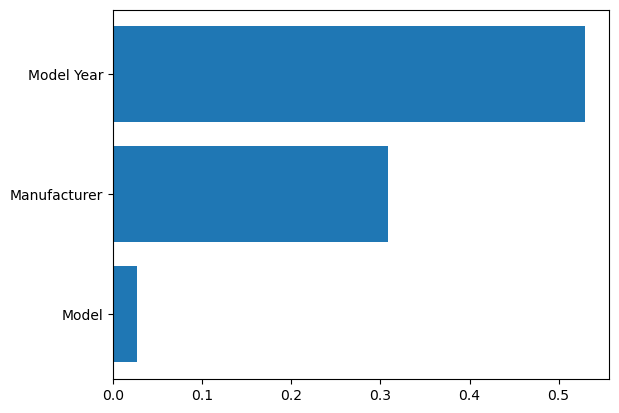

In [40]:
# Calculate feature importance on Ridge Model

coef = rr.coef_
feature_importance = np.abs(coef)

# Plot feature importance

def f_importances(coef, names):
    imp = coef[0]
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


f_importances(feature_importance, list(X.columns))

In [41]:
param_grid = {'alpha': [0.1, 0.5, 1], 'fit_intercept': [True, False],'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

grid = GridSearchCV(rr,param_grid,refit=True,verbose=1)
grid.fit(X_train_scaled,y_train)
print(grid.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}


              precision    recall  f1-score   support

         0.0       0.79      0.91      0.84       976
         1.0       0.90      0.76      0.82      1015

    accuracy                           0.83      1991
   macro avg       0.84      0.84      0.83      1991
weighted avg       0.84      0.83      0.83      1991



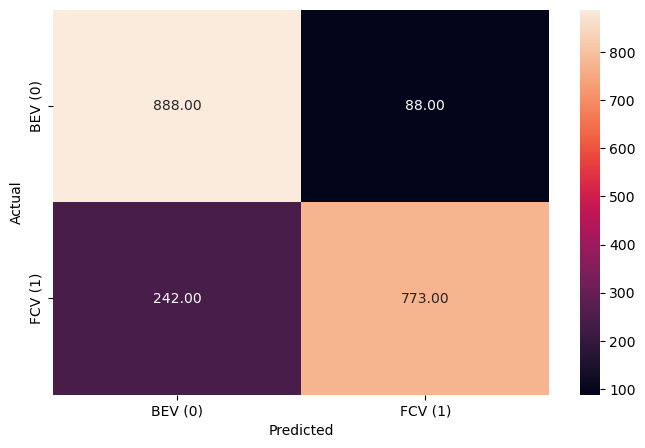

In [42]:
strong_grid_predictions = grid.predict(X_test_scaled)
strong_tuned_accuracy_score = accuracy_score(y_test, strong_grid_predictions)
metrics_score(y_test, strong_grid_predictions)

In [45]:


comparison_df = pd.DataFrame({'Data' : ['Overall Data', 'Weak Features', 'Best Features'],
                            'Accuracy' : [str(round(ovr_accuracy_score * 100, 2)) + '%',
                                            str(round(weak_accuracy_score * 100, 2)) + '%',
                                            str(round(strong_accuracy_score * 100, 2)) + '%'],
                            'Tuned Accuracy' : [str(round(ovr_tuned_accuracy_score * 100, 2)) + '%',
                                                str(round(weak_tuned_accuracy_score * 100, 2)) + '%',
                                                str(round(strong_tuned_accuracy_score * 100, 2)) + '%']})
comparison_df

,Data,Accuracy,Tuned Accuracy
0,Overall Data,83.07%,83.02%
1,Weak Features,61.23%,61.23%
2,Best Features,83.43%,83.43%
